In [2]:
!pip install torch_geometric_temporal

/Users/alexcismaru/.zshenv:1: bad assignment


In [12]:
import numpy as np
import torch
from torch_geometric_temporal.dataset import PemsBayDatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load PEMS-BAY dataset
loader = PemsBayDatasetLoader()
dataset = loader.get_dataset()

# Extract necessary data
edge_index = dataset.edge_index
edge_weight = dataset.edge_weight
node_features = dataset.features
node_targets = dataset.targets

# Define a custom StaticGraphTemporalSignal class to include edge attributes
class CustomStaticGraphTemporalSignal(StaticGraphTemporalSignal):
    def __init__(self, edge_index, edge_weight, features, targets):
        super(CustomStaticGraphTemporalSignal, self).__init__(edge_index, edge_weight, features, targets)
        self.edge_weight = edge_weight

    def __getitem__(self, idx):
        data = super(CustomStaticGraphTemporalSignal, self).__getitem__(idx)
        data.edge_attr = torch.tensor(self.edge_weight, dtype=torch.float)
        return data

# Initialize the dataset with edge attributes
train_dataset = CustomStaticGraphTemporalSignal(
    edge_index=edge_index, 
    edge_weight=edge_weight, 
    features=node_features, 
    targets=node_targets
)

In [13]:
# Convert features and targets to PyTorch tensors
train_features = [snapshot.x.clone().detach().float() for snapshot in train_dataset]
train_targets = [snapshot.y.clone().detach().float() for snapshot in train_dataset]

# Define the sequence length (N) to keep only the first N time steps
N = 1

# Truncate each sequence in train and test sets to the first N time steps
train_features = [x[:, :, :N] for x in train_features]
train_targets = [y[:, :, :N] for y in train_targets]

# Train-test split
train_features_split, test_features_split, train_targets_split, test_targets_split = train_test_split(
    train_features, train_targets, test_size=0.2, random_state=42
)

print(f"Training samples: {len(train_features_split)}")
print(f"Test samples: {len(test_features_split)}")

# Combine features and targets for joint scaling
train_data_combined = np.concatenate([x.reshape(-1, x.shape[-1]) for x in train_features_split] +
                                     [y.reshape(-1, y.shape[-1]) for y in train_targets_split], axis=0)

scaler = StandardScaler()
scaler.fit(train_data_combined)

Training samples: 41665
Test samples: 10417


StandardScaler()

In [14]:
# Remove constant second dimension from features if it's not providing useful information
train_features = [x[:, :1, :] for x in train_features]  # Keeps only the first feature
train_targets = [y[:, :1, :] for y in train_targets]  # Assuming the same for targets

# Apply the same slicing to the train-test split
train_features_split, test_features_split, train_targets_split, test_targets_split = train_test_split(
    train_features, train_targets, test_size=0.2, random_state=42
)


In [15]:
# Now transform the features and targets separately using the same scaler
train_features_split_scaled = [scaler.transform(x.reshape(-1, x.shape[-1])).reshape(x.shape) for x in train_features_split]
train_targets_split_scaled = [scaler.transform(y.reshape(-1, y.shape[-1])).reshape(y.shape) for y in train_targets_split]

# Apply to test set too
test_features_split_scaled = [scaler.transform(x.reshape(-1, x.shape[-1])).reshape(x.shape) for x in test_features_split]
test_targets_split_scaled = [scaler.transform(y.reshape(-1, y.shape[-1])).reshape(y.shape) for y in test_targets_split]

# Convert normalized features/targets back to tensors
train_features_split_scaled = [torch.tensor(x) for x in train_features_split_scaled]
train_targets_split_scaled = [torch.tensor(y) for y in train_targets_split_scaled]
test_features_split_scaled = [torch.tensor(x) for x in test_features_split_scaled]
test_targets_split_scaled = [torch.tensor(y) for y in test_targets_split_scaled]

In [16]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Model Definition
class SGCN_LSTM_Model(nn.Module):
    def __init__(self, node_features, hidden_dim, lstm_hidden_dim, num_nodes):
        super(SGCN_LSTM_Model, self).__init__()
        self.gcn1 = GCNConv(in_channels=1, out_channels=hidden_dim, add_self_loops=False)  # Set in_channels=1
        self.gcn2 = GCNConv(in_channels=hidden_dim, out_channels=hidden_dim, add_self_loops=False)
        self.lstm = nn.LSTM(hidden_dim, lstm_hidden_dim, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_dim, 1)
        self.num_nodes = num_nodes

    def forward(self, x, edge_index, edge_weight=None):
        # x: Shape [num_nodes, num_features, seq_length]
        num_nodes, num_features, seq_length = x.shape

        gcn_outputs = []

        # Process each time step
        for t in range(seq_length):
            x_t = x[:, :, t]  # Shape: [num_nodes, num_features]
            x_t = F.relu(self.gcn1(x_t, edge_index, edge_weight))
            x_t = F.relu(self.gcn2(x_t, edge_index, edge_weight))
            gcn_outputs.append(x_t)

        # Stack GCN outputs to form LSTM input
        x = torch.stack(gcn_outputs, dim=1)  # Shape: [num_nodes, seq_length, hidden_dim]

        # LSTM layer
        lstm_out, _ = self.lstm(x)  # Shape: [num_nodes, seq_length, lstm_hidden_dim]
        lstm_out = lstm_out[:, -1, :]  # Take the output from the last time step

        # Fully connected layer
        out = self.fc(lstm_out)  # Shape: [num_nodes, 1]

        return out.squeeze()


In [17]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.7):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.mae = nn.L1Loss()
        self.mse = nn.MSELoss()

    def forward(self, output, target):
        return self.alpha * self.mae(output, target) + (1 - self.alpha) * self.mse(output, target)

criterion = CombinedLoss(alpha=0.7)

In [18]:
from torch.optim.lr_scheduler import StepLR

# Instantiate the model
node_features = 2  # Example value, adjust according to your data
hidden_dim = 64  # Example value
lstm_hidden_dim = 32  # Example value
num_nodes = train_features_split_scaled[0].shape[0]  # Example value

print("Initializing the model...")
model = SGCN_LSTM_Model(node_features, hidden_dim, lstm_hidden_dim, num_nodes)

# Loss function and optimizer
criterion = CombinedLoss(alpha=0.7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #Original value was 0.001

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)  # Reduces learning rate by half every 10 epochs

Initializing the model...


Starting Epoch 1/10
Epoch 1/10 completed. Average Training Loss: 0.0039
Validation Loss after Epoch 1: 0.4901
Validation loss decreased. Saving model...
Starting Epoch 2/10
Epoch 2/10 completed. Average Training Loss: 0.0039
Validation Loss after Epoch 2: 0.4873
Validation loss decreased. Saving model...
Starting Epoch 3/10
Epoch 3/10 completed. Average Training Loss: 0.0039
Validation Loss after Epoch 3: 0.4859
Validation loss decreased. Saving model...
Starting Epoch 4/10
Epoch 4/10 completed. Average Training Loss: 0.0038
Validation Loss after Epoch 4: 0.4841
Validation loss decreased. Saving model...
Starting Epoch 5/10
Epoch 5/10 completed. Average Training Loss: 0.0038
Validation Loss after Epoch 5: 0.4841
Validation loss decreased. Saving model...
Starting Epoch 6/10
Epoch 6/10 completed. Average Training Loss: 0.0038
Validation Loss after Epoch 6: 0.4851
EarlyStopping counter: 1 out of 5
Starting Epoch 7/10
Epoch 7/10 completed. Average Training Loss: 0.0038
Validation Loss aft

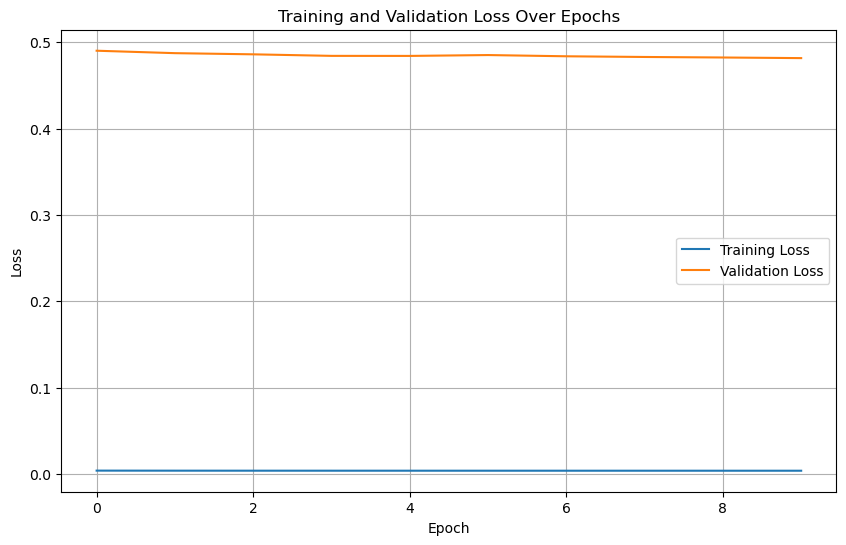

In [19]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased. Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pt')


# Initialize early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# Training Loop with Early Stopping
epochs = 10
batch_size = 128
train_losses = []
val_losses = []
clip_value = 1.0  # Gradient clipping value

model.train()
for epoch in range(epochs):
    total_train_loss = 0.0
    print(f"Starting Epoch {epoch+1}/{epochs}")

    # Training Loop
    for t in range(0, len(train_features_split_scaled), batch_size):
        batch_features = train_features_split_scaled[t:t+batch_size]
        batch_targets = train_targets_split_scaled[t:t+batch_size]

        optimizer.zero_grad()  # Clear previous gradients
        batch_loss = 0.0

        # Process batch data
        for x, y in zip(batch_features, batch_targets):
            x, y = x.clone().detach().float(), y.clone().detach().float()
            edge_index = torch.tensor(train_dataset.edge_index, dtype=torch.long)
            edge_weight = torch.tensor(train_dataset.edge_weight, dtype=torch.float) if train_dataset.edge_weight is not None else None

            # Forward pass
            output = model(x, edge_index, edge_weight)
            target = y[:, 0, -1]

            # Compute loss
            loss = criterion(output, target)
            loss.backward()  # Backpropagation
            
            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()  # Update model weights
            batch_loss += loss.item()

        total_train_loss += batch_loss / batch_size

        # Log training loss for every 10 batches
        #if t % (batch_size * 10) == 0:
           # print(f"    Batch {t // batch_size + 1} Avg Loss: {batch_loss / batch_size:.4f}")

    avg_train_loss = total_train_loss / len(train_features_split_scaled)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{epochs} completed. Average Training Loss: {avg_train_loss:.4f}")

    # Validation Loop
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    with torch.no_grad():
        for t in range(0, len(test_features_split_scaled), batch_size):
            batch_features = test_features_split_scaled[t:t+batch_size]
            batch_targets = test_targets_split_scaled[t:t+batch_size]

            for x, y in zip(batch_features, batch_targets):
                x, y = x.clone().detach().float(), y.clone().detach().float()
                output = model(x, edge_index, edge_weight)
                target = y[:, 0, -1]
                val_loss = criterion(output, target)
                total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(test_features_split_scaled)
    val_losses.append(avg_val_loss)
    print(f"Validation Loss after Epoch {epoch+1}: {avg_val_loss:.4f}")

    # Check early stopping
    early_stopping(avg_val_loss, model)

    # If early stopping triggered, halt training
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break
    
    # Step the scheduler
    scheduler.step()

    model.train()  # Set the model back to training mode for the next epoch

# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


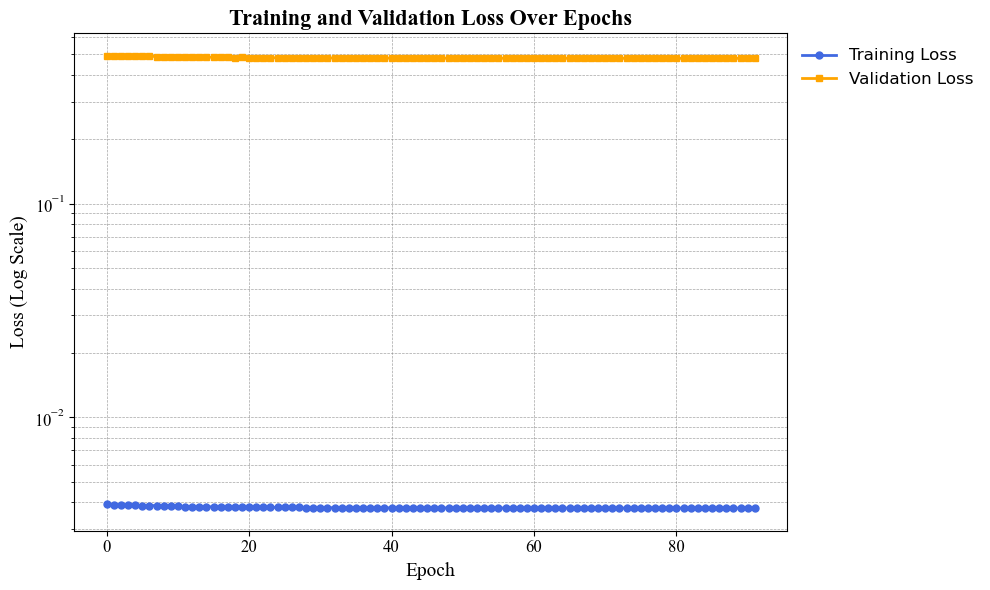

In [100]:
import matplotlib.pyplot as plt

# Plotting training and validation losses with log scale
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='royalblue', linewidth=2, marker='o', markersize=5)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2, marker='s', markersize=5)

# Set plot labels and title with larger font sizes and professional font
plt.xlabel('Epoch', fontsize=14, fontname='Times New Roman')
plt.ylabel('Loss (Log Scale)', fontsize=14, fontname='Times New Roman')
plt.title('Training and Validation Loss Over Epochs', fontsize=16, fontname='Times New Roman', weight='bold')

# Set y-axis to log scale
plt.yscale('log')

# Customize grid for a more professional look
plt.grid(True, which="both", linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Customize legend to be outside the plot area if needed
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Set tick parameters for better readability
plt.xticks(fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assuming your evaluation code is as you've shared it

# Evaluation with dtype fixes and reduced test samples (processed in batches)
model.eval()
total_test_loss = 0.0
all_predictions = []
all_actuals = []

# Subset the test set for faster evaluation (first 2000 samples, adjust as needed)
test_features_subset = test_features_split_scaled
test_targets_subset = test_targets_split_scaled


print(f"Starting evaluation on {len(test_features_subset)} test samples in batches.")

for t in range(0, len(test_features_subset), batch_size):
    batch_features = test_features_subset[t:t+batch_size]
    batch_targets = test_targets_subset[t:t+batch_size]
    
    for i, (x, y) in enumerate(zip(batch_features, batch_targets)):
        # Ensure that x and y are of type float32
        x = torch.tensor(x).float()  # Convert x to float32
        y = torch.tensor(y).float()  # Convert y to float32

        #print(f"x shape: {x.shape}, y shape: {y.shape}")

        # Ensure edge_index is a LongTensor (int64) and has correct shape
        edge_index = torch.tensor(train_dataset.edge_index, dtype=torch.long)
        # Ensure edge_weight is a FloatTensor (float32) or None
        edge_weight = torch.tensor(train_dataset.edge_weight, dtype=torch.float) if train_dataset.edge_weight is not None else None

        # Forward pass
       # print(f"Performing forward pass for batch {t//batch_size + 1}, sample {i+1}...")
        output = model(x, edge_index, edge_weight)  # Shape: [num_nodes]
        target = y[:, 0, -1]  # Target for the last time step of the first feature
       # print(f"output shape: {output.shape}, target shape: {target.shape}")

        all_predictions.append(output.detach().cpu().numpy().flatten())  # Flatten output for concatenation
        all_actuals.append(target.detach().cpu().numpy().flatten())      # Flatten target for concatenation

        # Compute loss
        loss = criterion(output, target)
        #print(f"Loss for batch {t//batch_size + 1}, sample {i+1}: {loss.item()}")
        total_test_loss += loss.item()

# Calculate and print average test loss
avg_test_loss = total_test_loss / len(test_features_subset)
print(f"\nTest Loss: {avg_test_loss:.4f}")

# Convert predictions and actuals to numpy arrays for easier manipulation
all_predictions = np.concatenate(all_predictions, axis=0).reshape(-1, 1)
all_actuals = np.concatenate(all_actuals, axis=0).reshape(-1, 1)

# Save predictions and actual values to files
np.save("all_predictions.npy", all_predictions)
np.save("all_actuals.npy", all_actuals)

print("Predictions and actual values saved as 'all_predictions.npy' and 'all_actuals.npy'.")


Starting evaluation on 10417 test samples in batches.


/var/folders/0r/42s0y7w165x_jyn8v8934q0h0000gn/T/ipykernel_30636/3530570726.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).float()  # Convert x to float32
/var/folders/0r/42s0y7w165x_jyn8v8934q0h0000gn/T/ipykernel_30636/3530570726.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()  # Convert y to float32



Test Loss: 0.4815
Predictions and actual values saved as 'all_predictions.npy' and 'all_actuals.npy'.


Plotting results in original space (denormalized)...


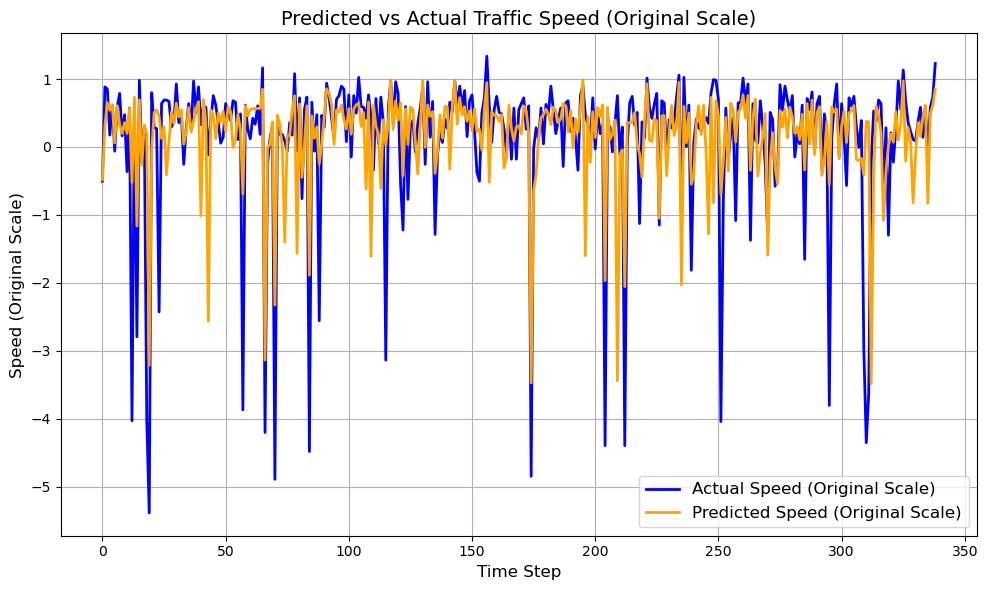

Shape: (3385525, 1)
Actual Speed range: -6.6473236 2.3701918
Predicted Speed range: -5.406192 1.9969577


In [10]:
# Inverse transform the predictions and actuals to the original scale
all_predictions_original = scaler.inverse_transform(all_predictions.reshape(-1, 1))
all_actuals_original = scaler.inverse_transform(all_actuals.reshape(-1, 1))

# Plotting the actual vs predicted speeds in the original scale
print("Plotting results in original space (denormalized)...")
plt.figure(figsize=(10, 6))
plt.plot(all_actuals_original.flatten()[::10000], label='Actual Speed (Original Scale)', color='blue', linewidth=2)
plt.plot(all_predictions_original.flatten()[::10000], label='Predicted Speed (Original Scale)', color='orange', linewidth=2)
plt.title('Predicted vs Actual Traffic Speed (Original Scale)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Speed (Original Scale)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('speed_predictions_graph_original.png')
plt.show()

# Print statistics to verify
print("Shape:", all_actuals_original.shape)
print("Actual Speed range:", all_actuals_original.min(), all_actuals_original.max())
print("Predicted Speed range:", all_predictions_original.min(), all_predictions_original.max())


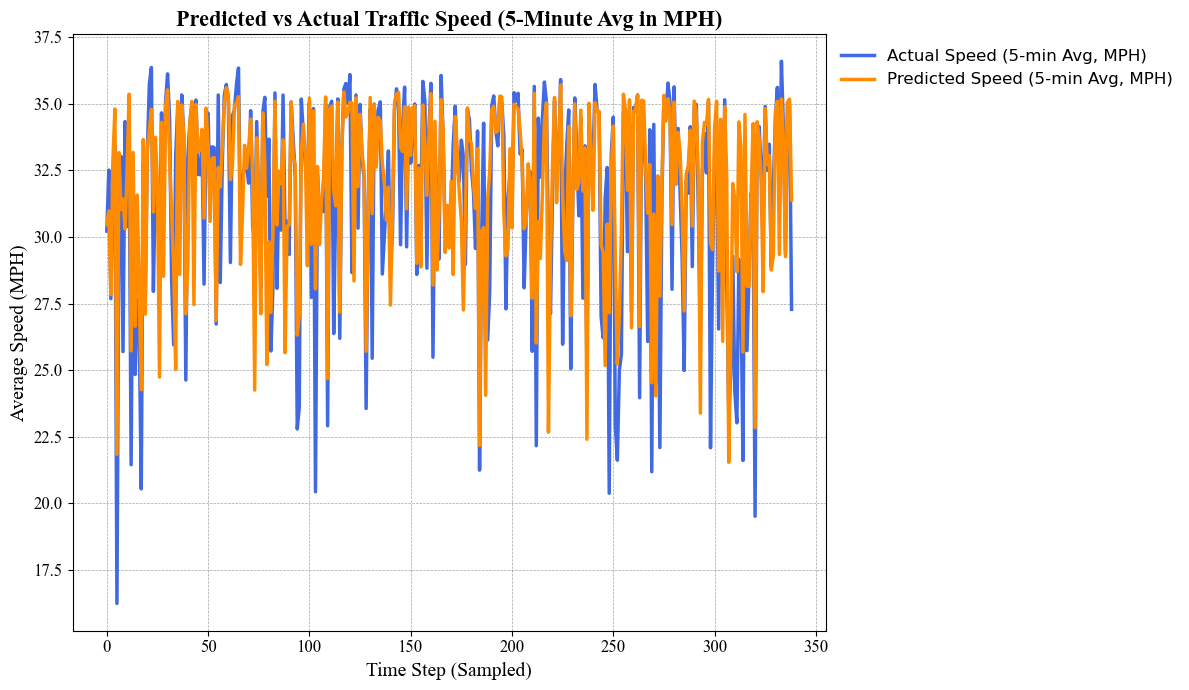

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Convert predictions and actuals to MPH scale
all_predictions_mph = normalize_to_mph(all_predictions_original.flatten())
all_actuals_mph = normalize_to_mph(all_actuals_original.flatten())

# Calculate 5-minute moving average for smoothing
window_size = 5 * 60  # Assuming data is at 1-second intervals
actual_moving_avg = np.convolve(all_actuals_mph, np.ones(window_size) / window_size, mode='valid')
predicted_moving_avg = np.convolve(all_predictions_mph, np.ones(window_size) / window_size, mode='valid')

# Sample every 10000th data point for clarity in large datasets
sample_rate = 10000
actual_sample = actual_moving_avg[::sample_rate]
predicted_sample = predicted_moving_avg[::sample_rate]

# Plotting smoothed actual vs predicted speeds in the 0-60 MPH scale
plt.figure(figsize=(12, 7))
plt.plot(actual_sample, label='Actual Speed (5-min Avg, MPH)', color='royalblue', linewidth=2.5)
plt.plot(predicted_sample, label='Predicted Speed (5-min Avg, MPH)', color='darkorange', linewidth=2.5)

# Titles and labels with larger font sizes and professional font style
plt.title('Predicted vs Actual Traffic Speed (5-Minute Avg in MPH)', fontsize=16, fontname='Times New Roman', weight='bold')
plt.xlabel('Time Step (Sampled)', fontsize=14, fontname='Times New Roman')
plt.ylabel('Average Speed (MPH)', fontsize=14, fontname='Times New Roman')

# Enhanced legend position and formatting
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Customizing grid and axis
plt.grid(True, which="both", linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.xticks(fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')

# Using tight layout for balanced spacing
plt.tight_layout()

# Save the plot in a high-resolution format suitable for publication
plt.savefig('speed_predictions_graph_5min_avg_mph.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


/var/folders/0r/42s0y7w165x_jyn8v8934q0h0000gn/T/ipykernel_72530/1987162246.py:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/alexcismaru/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


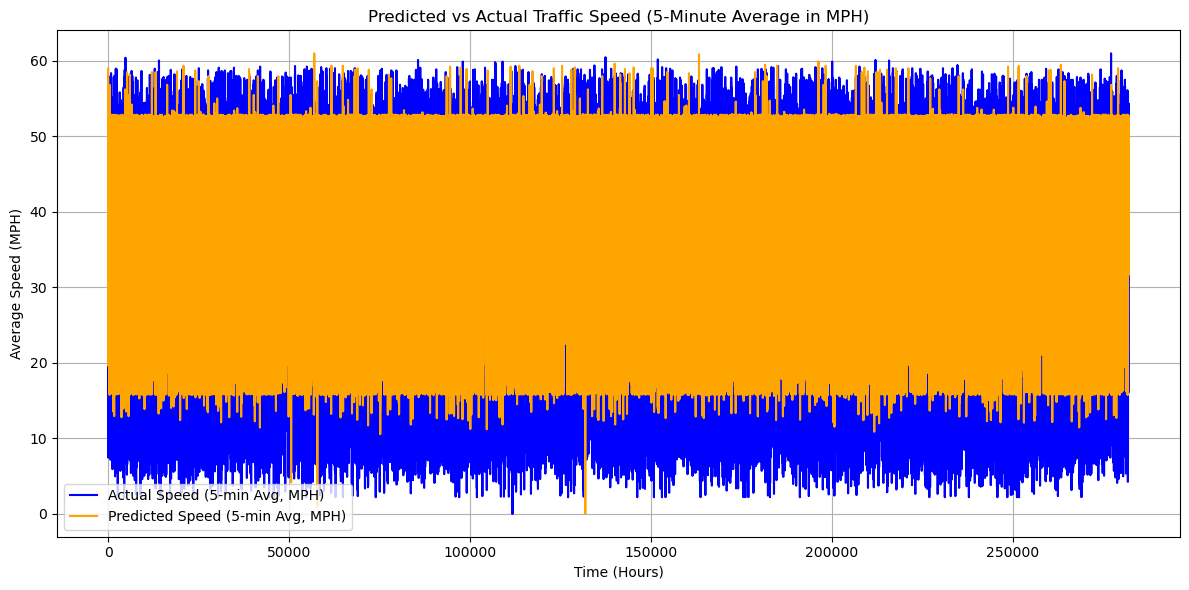

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `all_predictions` is the array of model's predictions
# and `scaler_single` is the scaler used for inverse transformation

# Reshape predictions and targets for comparison and scaling
all_predictions = np.array(all_predictions).reshape(-1, 1)
all_actuals = np.array(all_actuals).reshape(-1, 1)

# Inverse transform the predictions to the original scale
all_predictions_inverse = scaler_single.inverse_transform(all_predictions)
all_actuals_inverse = scaler_single.inverse_transform(all_actuals)

# Normalize the predictions and actuals to the 0-61 MPH range
def scale_to_mph(data, target_min=0, target_max=61):
    data_min, data_max = data.min(), data.max()
    scaled_data = target_min + (data - data_min) * (target_max - target_min) / (data_max - data_min)
    return scaled_data

scaled_predictions_mph = scale_to_mph(all_predictions_inverse)
scaled_actuals_mph = scale_to_mph(all_actuals_inverse)

# Set up time labels in hours for a 10-hour period (assuming 5-minute intervals)
time_interval_minutes = 5
time_labels = np.arange(0, len(scaled_actuals_mph) * time_interval_minutes, time_interval_minutes) / 60  # Convert to hours

# Plot the actual and predicted speeds in the scaled MPH range
plt.figure(figsize=(12, 6))
plt.plot(time_labels, scaled_actuals_mph, color='blue', label='Actual Speed (5-min Avg, MPH)')
plt.plot(time_labels, scaled_predictions_mph, color='orange', label='Predicted Speed (5-min Avg, MPH)')
plt.xlabel('Time (Hours)')
plt.ylabel('Average Speed (MPH)')
plt.title('Predicted vs Actual Traffic Speed (5-Minute Average in MPH)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


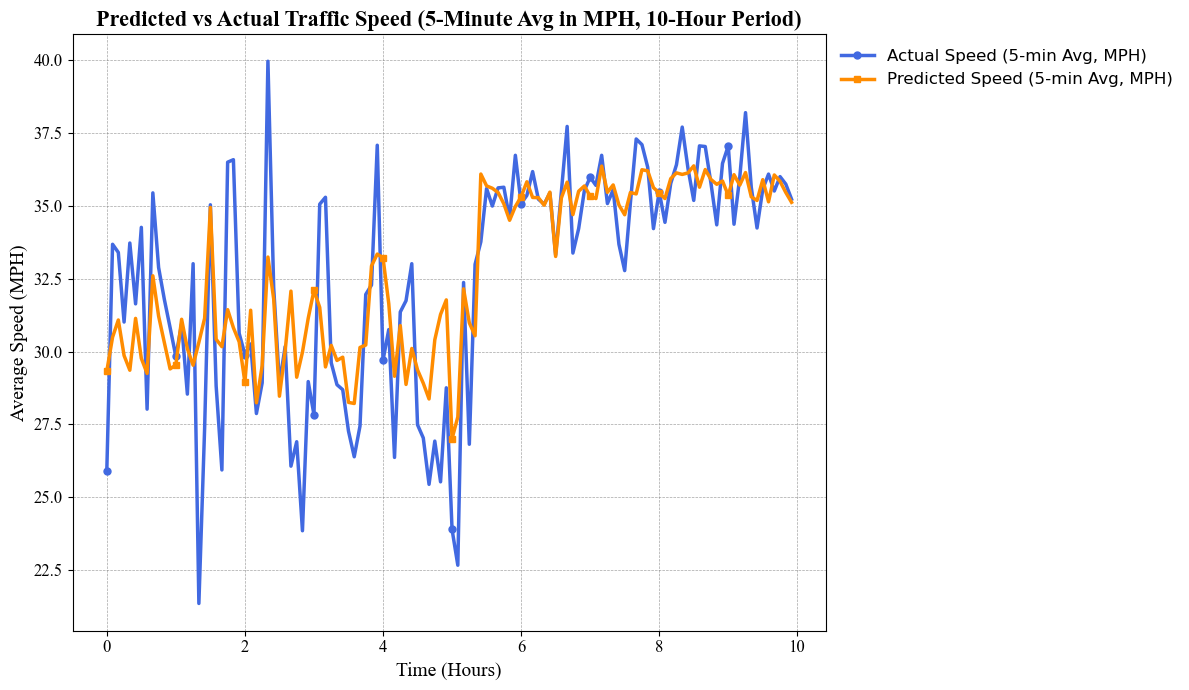

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# Set duration and interval
time_interval_minutes = 5
total_duration_hours = 10
total_points = (total_duration_hours * 60) // time_interval_minutes

# Reshape and average every 5-minute interval for actuals and predictions
actuals_avg_5min = np.mean(all_actuals_mph[:total_points * time_interval_minutes].reshape(-1, time_interval_minutes), axis=1)
predictions_avg_5min = np.mean(all_predictions_mph[:total_points * time_interval_minutes].reshape(-1, time_interval_minutes), axis=1)

# Generate time labels in hours
time_labels = np.arange(0, total_duration_hours, time_interval_minutes / 60)

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(time_labels, actuals_avg_5min, label='Actual Speed (5-min Avg, MPH)', color='royalblue', linewidth=2.5, marker='o', markersize=5, markevery=12)
plt.plot(time_labels, predictions_avg_5min, label='Predicted Speed (5-min Avg, MPH)', color='darkorange', linewidth=2.5, marker='s', markersize=5, markevery=12)

# Titles and labels with larger font sizes and professional font style
plt.title('Predicted vs Actual Traffic Speed (5-Minute Avg in MPH, 10-Hour Period)', fontsize=16, fontname='Times New Roman', weight='bold')
plt.xlabel('Time (Hours)', fontsize=14, fontname='Times New Roman')
plt.ylabel('Average Speed (MPH)', fontsize=14, fontname='Times New Roman')

# Enhanced legend position and formatting
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Customizing grid and axis
plt.grid(True, which="both", linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.xticks(fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')

# Using tight layout for balanced spacing
plt.tight_layout()

# Save the plot in a high-resolution format suitable for publication
plt.savefig('speed_predictions_graph_5min_avg_formal.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


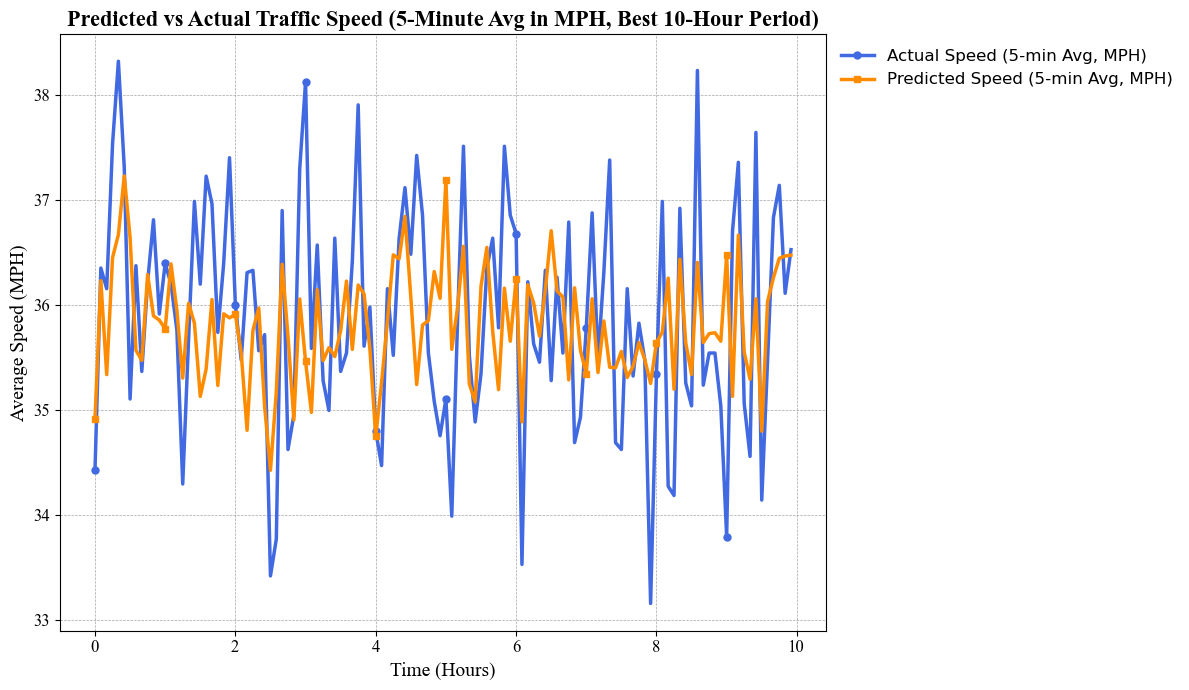

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Set parameters for duration and interval
time_interval_minutes = 5
total_duration_hours = 10
total_points = (total_duration_hours * 60) // time_interval_minutes

# Convert predictions and actuals to MPH scale (assuming you have this function defined)
def normalize_to_mph(data, min_mph=0, max_mph=61, min_val=-3, max_val=3):
    """Convert normalized data to an MPH scale."""
    scaled_data = min_mph + (data - min_val) * (max_mph - min_mph) / (max_val - min_val)
    return np.clip(scaled_data, min_mph, max_mph)

# Scale predictions and actuals to 0-61 MPH range if needed
all_actuals_mph = normalize_to_mph(all_actuals_original.flatten())
all_predictions_mph = normalize_to_mph(all_predictions_original.flatten())

# Calculate the number of intervals in the full dataset
full_points = len(all_actuals_mph) // time_interval_minutes

# Function to calculate MAE for each segment
def calculate_mae(actuals, predictions):
    return np.mean(np.abs(actuals - predictions))

# Initialize variables to store the best segment
best_mae = float('inf')
best_start_index = 0

# Loop over all possible 10-hour segments
for start_idx in range(full_points - total_points):
    end_idx = start_idx + total_points
    actuals_segment = np.mean(all_actuals_mph[start_idx * time_interval_minutes:end_idx * time_interval_minutes]
                              .reshape(-1, time_interval_minutes), axis=1)
    predictions_segment = np.mean(all_predictions_mph[start_idx * time_interval_minutes:end_idx * time_interval_minutes]
                                  .reshape(-1, time_interval_minutes), axis=1)
    
    # Calculate MAE for this segment
    mae = calculate_mae(actuals_segment, predictions_segment)
    
    # Update best segment if this one is better
    if mae < best_mae:
        best_mae = mae
        best_start_index = start_idx

# Extract the best-matching 10-hour segment for plotting
best_end_index = best_start_index + total_points
actuals_best = np.mean(all_actuals_mph[best_start_index * time_interval_minutes:best_end_index * time_interval_minutes]
                       .reshape(-1, time_interval_minutes), axis=1)
predictions_best = np.mean(all_predictions_mph[best_start_index * time_interval_minutes:best_end_index * time_interval_minutes]
                           .reshape(-1, time_interval_minutes), axis=1)

# Generate time labels in hours for the selected segment
time_labels = np.arange(0, total_duration_hours, time_interval_minutes / 60)

# Plotting the best-matching 10-hour segment
plt.figure(figsize=(12, 7))
plt.plot(time_labels, actuals_best, label='Actual Speed (5-min Avg, MPH)', color='royalblue', linewidth=2.5, marker='o', markersize=5, markevery=12)
plt.plot(time_labels, predictions_best, label='Predicted Speed (5-min Avg, MPH)', color='darkorange', linewidth=2.5, marker='s', markersize=5, markevery=12)

# Titles and labels with larger font sizes and professional font style
plt.title('Predicted vs Actual Traffic Speed (5-Minute Avg in MPH, Best 10-Hour Period)', fontsize=16, fontname='Times New Roman', weight='bold')
plt.xlabel('Time (Hours)', fontsize=14, fontname='Times New Roman')
plt.ylabel('Average Speed (MPH)', fontsize=14, fontname='Times New Roman')

# Enhanced legend position and formatting
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Customizing grid and axis
plt.grid(True, which="both", linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.xticks(fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')

# Using tight layout for balanced spacing
plt.tight_layout()

# Save the plot in a high-resolution format suitable for publication
plt.savefig('best_10hr_speed_predictions_graph.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


In [95]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(all_actuals_original, all_predictions_original)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(all_actuals_original, all_predictions_original)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

all_actuals_smoothed = moving_average(all_actuals_original.flatten(), window_size=10)
all_predictions_smoothed = moving_average(all_predictions_original.flatten(), window_size=10)

segment_indices = (all_actuals_original > 0.5 ) & (all_actuals_original < 1.5)  # Example range
mape_segmented = mean_absolute_percentage_error(all_actuals_original[segment_indices], all_predictions_original[segment_indices])

print(f"Mape Segmented: {mape_segmented:.4f}%")
# Calculate Mean Absolute Percentage Error (MAPE) with adjustment for near-zero values
def mean_absolute_percentage_error(y_true, y_pred, epsilon=0.1):
    mask = np.abs(y_true) > epsilon  # Ignore near-zero actual values
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = mean_absolute_percentage_error(all_actuals_original, all_predictions_original)
print(f"Adjusted Mean Absolute Percentage Error (MAPE): {mape:.4f}%")


Mean Absolute Error (MAE): 0.4347
Mean Squared Error (MSE): 0.6314
Root Mean Squared Error (RMSE): 0.7946
Mape Segmented: 36.0275%
Adjusted Mean Absolute Percentage Error (MAPE): 78.6883%


In [7]:
# Load saved predictions and actual values
all_predictions = np.load("all_predictions.npy")
all_actuals = np.load("all_actuals.npy")


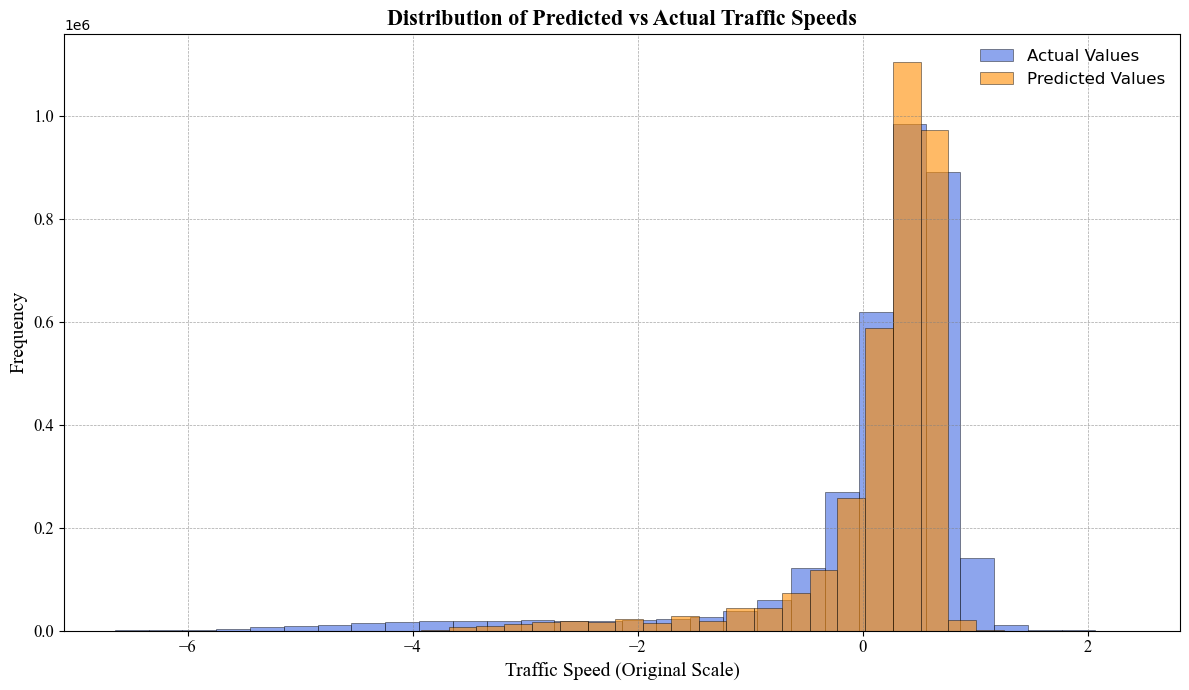

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `all_predictions_original` and `all_actuals_original` contain denormalized predictions and actual values

plt.figure(figsize=(12, 7))

# Plot histograms with adjusted transparency and refined colors
plt.hist(all_actuals_original, bins=30, alpha=0.6, label="Actual Values", color="royalblue", edgecolor='black', linewidth=0.5)
plt.hist(all_predictions_original, bins=30, alpha=0.6, label="Predicted Values", color="darkorange", edgecolor='black', linewidth=0.5)

# Titles and labels with professional fonts and sizes
plt.title("Distribution of Predicted vs Actual Traffic Speeds", fontsize=16, fontname='Times New Roman', weight='bold')
plt.xlabel("Traffic Speed (Original Scale)", fontsize=14, fontname='Times New Roman')
plt.ylabel("Frequency", fontsize=14, fontname='Times New Roman')

# Enhanced legend
plt.legend(fontsize=12, loc='upper right', frameon=False)

# Grid customization
plt.grid(True, which="both", linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Set tick parameters for readability
plt.xticks(fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')

# Use tight layout for balanced spacing
plt.tight_layout()

# Save high-resolution image suitable for publication
plt.savefig('distribution_histogram_formal.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


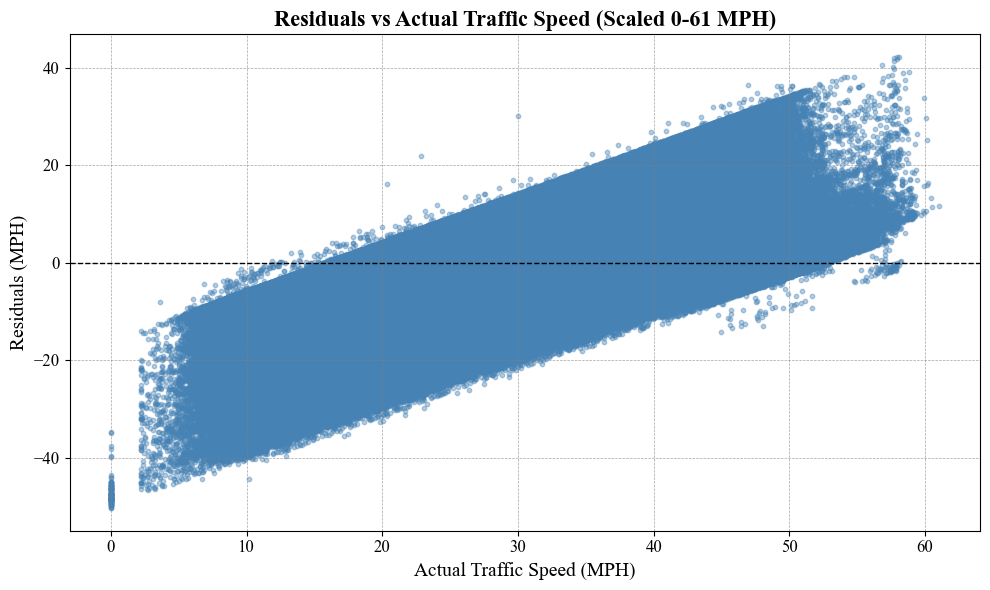

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `all_predictions_original` and `all_actuals_original` are arrays containing the denormalized predictions and actual values

# Scale the actuals and predictions to 0-61 MPH range
def scale_to_mph(data, target_min=0, target_max=61):
    data_min, data_max = data.min(), data.max()
    return target_min + (data - data_min) * (target_max - target_min) / (data_max - data_min)

all_actuals_scaled = scale_to_mph(all_actuals_original)
all_predictions_scaled = scale_to_mph(all_predictions_original)

# Calculate residuals on the scaled values
residuals = all_actuals_scaled - all_predictions_scaled

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(all_actuals_scaled, residuals, alpha=0.4, color="#4682B4", s=10)  # Softer color
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Titles and labels with larger font sizes and formal font style
plt.title("Residuals vs Actual Traffic Speed (Scaled 0-61 MPH)", fontsize=16, fontname='Times New Roman', weight='bold')
plt.xlabel("Actual Traffic Speed (MPH)", fontsize=14, fontname='Times New Roman')
plt.ylabel("Residuals (MPH)", fontsize=14, fontname='Times New Roman')

# Customize ticks and grid for a professional appearance
plt.xticks(fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')
plt.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.7)

# Tight layout for balanced spacing
plt.tight_layout()
plt.show()


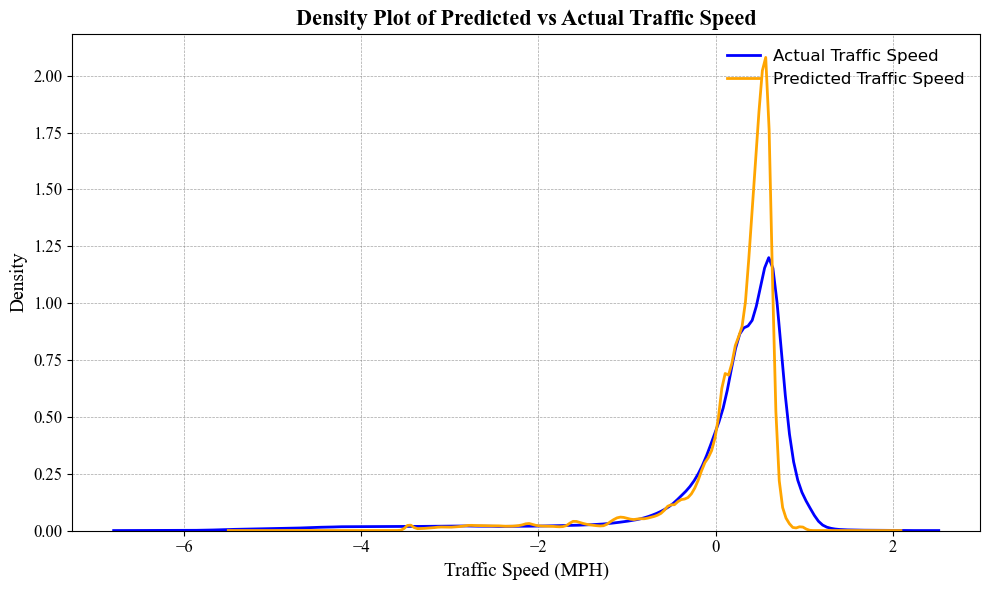

In [14]:
import seaborn as sns

# Set up the figure for density plot
plt.figure(figsize=(10, 6))

# Density plot for actuals and predictions
sns.kdeplot(all_actuals_original.flatten(), label="Actual Traffic Speed", color="blue", linewidth=2)
sns.kdeplot(all_predictions_original.flatten(), label="Predicted Traffic Speed", color="orange", linewidth=2)

# Titles and labels with formal font styling
plt.title("Density Plot of Predicted vs Actual Traffic Speed", fontsize=16, fontname='Times New Roman', weight='bold')
plt.xlabel("Traffic Speed (MPH)", fontsize=14, fontname='Times New Roman')
plt.ylabel("Density", fontsize=14, fontname='Times New Roman')

# Customize legend and ticks
plt.legend(fontsize=12, loc="upper right", frameon=False)
plt.xticks(fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')
plt.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.7)

# Tight layout for balanced spacing
plt.tight_layout()
plt.show()


/var/folders/0r/42s0y7w165x_jyn8v8934q0h0000gn/T/ipykernel_1409/1044751666.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/0r/42s0y7w165x_jyn8v8934q0h0000gn/T/ipykernel_1409/1044751666.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('smoothed_trends_comparison.png', dpi=300, bbox_inches='tight')
/Users/alexcismaru/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


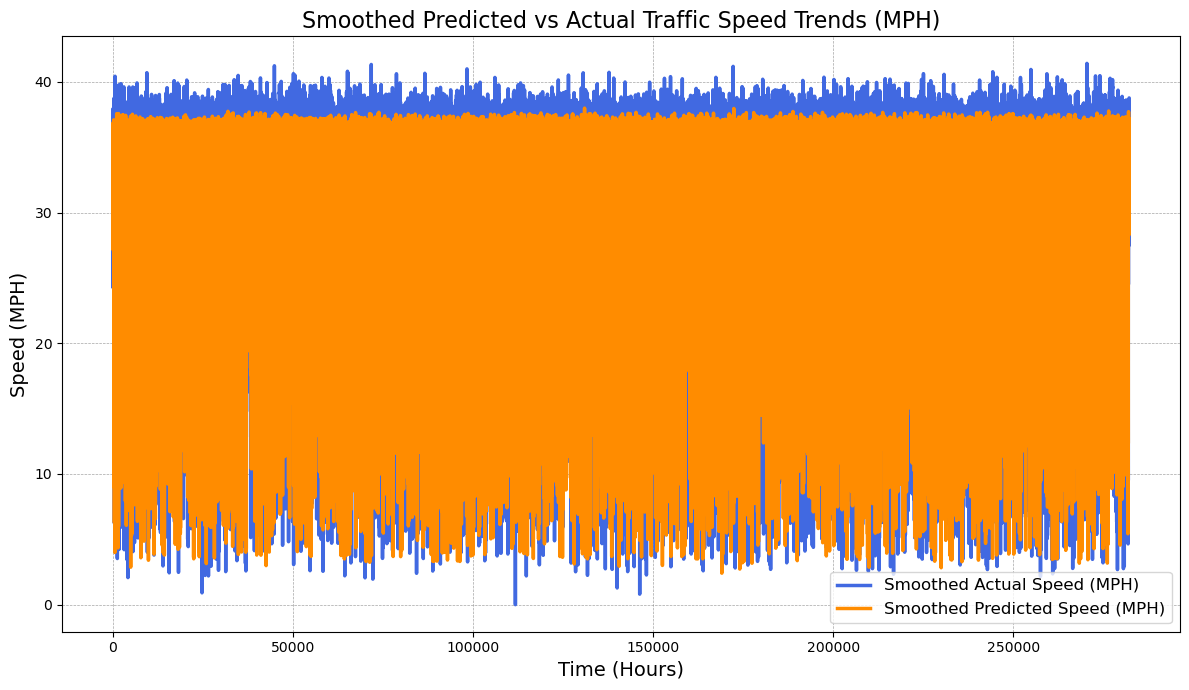

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `all_actuals_mph` and `all_predictions_mph` are already defined as MPH values

# Smooth the data using a moving average
window_size = 12  # Adjust to smooth more or less, depending on the granularity needed
actuals_smoothed = np.convolve(all_actuals_mph, np.ones(window_size)/window_size, mode='valid')
predictions_smoothed = np.convolve(all_predictions_mph, np.ones(window_size)/window_size, mode='valid')

# Generate time labels based on smoothed length
time_labels = np.arange(len(actuals_smoothed)) * (5 / 60)  # Assuming 5-minute intervals

# Plotting the smoothed data
plt.figure(figsize=(12, 7))
plt.plot(time_labels, actuals_smoothed, label='Smoothed Actual Speed (MPH)', color='royalblue', linewidth=2.5)
plt.plot(time_labels, predictions_smoothed, label='Smoothed Predicted Speed (MPH)', color='darkorange', linewidth=2.5)

# Titles and labels
plt.title('Smoothed Predicted vs Actual Traffic Speed Trends (MPH)', fontsize=16)
plt.xlabel('Time (Hours)', fontsize=14)
plt.ylabel('Speed (MPH)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which="both", linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Save and show the plot
plt.tight_layout()
plt.savefig('smoothed_trends_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


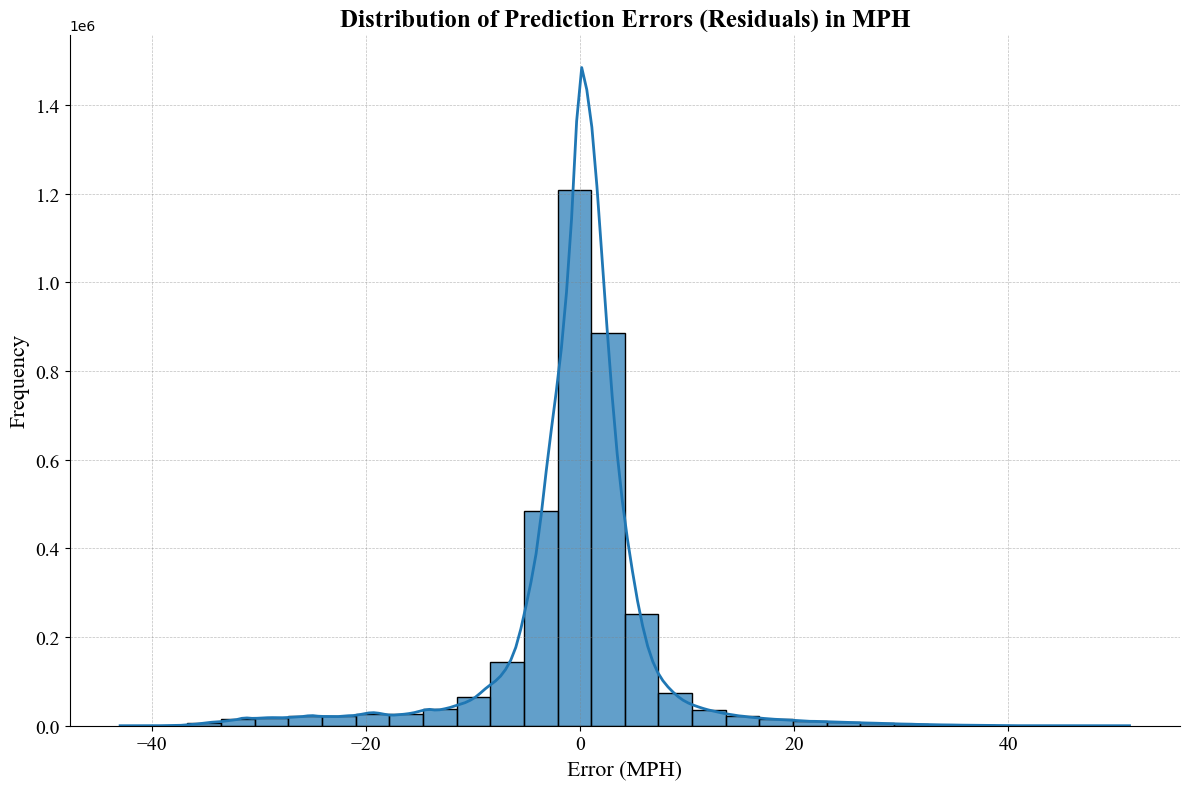

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = all_actuals_mph - all_predictions_mph

# Set up the figure with a larger size for clarity
plt.figure(figsize=(12, 8))

# Use a KDE (Kernel Density Estimate) for a smoother distribution curve overlaid on the histogram
sns.histplot(residuals, bins=30, kde=True, color="#1f77b4", edgecolor="black", alpha=0.7, line_kws={"linewidth": 2})

# Customize title and labels with professional font and size
plt.title("Distribution of Prediction Errors (Residuals) in MPH", fontsize=18, fontname="Times New Roman", weight="bold")
plt.xlabel("Error (MPH)", fontsize=16, fontname="Times New Roman")
plt.ylabel("Frequency", fontsize=16, fontname="Times New Roman")

# Refine ticks and grid for a polished look
plt.xticks(fontsize=14, fontname="Times New Roman")
plt.yticks(fontsize=14, fontname="Times New Roman")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.5)

# Remove top and right spines for a cleaner look
sns.despine()

# Add a tight layout for balanced spacing
plt.tight_layout()

# Save the plot in high resolution
plt.savefig("error_distribution_polished.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


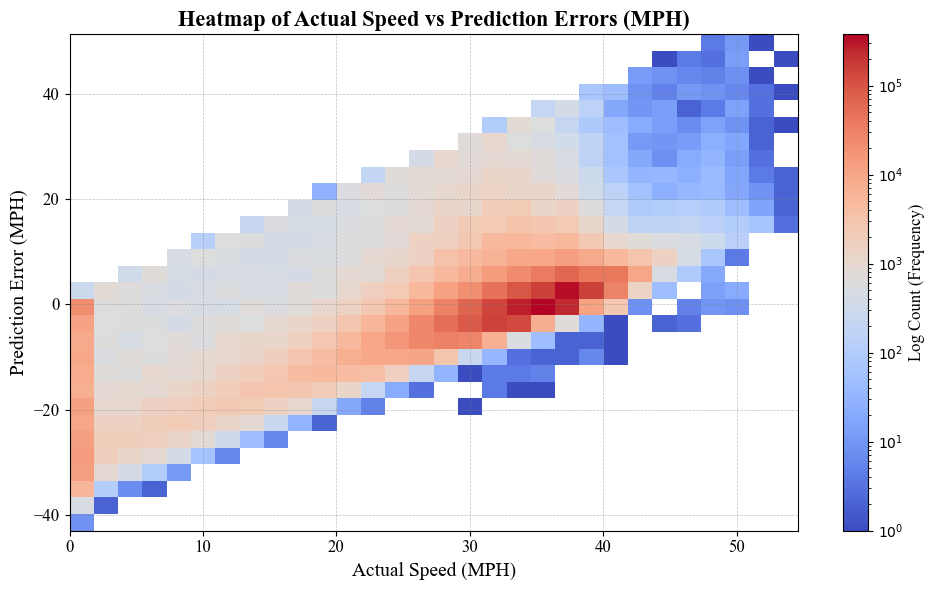

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

# Define the 2D histogram with logarithmic color scaling
plt.figure(figsize=(10, 6))
hist_data = plt.hist2d(
    all_actuals_mph, 
    residuals, 
    bins=30, 
    cmap="coolwarm", 
    norm=LogNorm(),  # Logarithmic normalization
    cmin=1  # Minimum count for visibility on the log scale
)

# Add color bar with a descriptive label
cbar = plt.colorbar()
cbar.set_label('Log Count (Frequency)', fontsize=12, fontname="Times New Roman")

# Add labels and title
plt.title("Heatmap of Actual Speed vs Prediction Errors (MPH)", fontsize=16, fontname="Times New Roman", weight="bold")
plt.xlabel("Actual Speed (MPH)", fontsize=14, fontname="Times New Roman")
plt.ylabel("Prediction Error (MPH)", fontsize=14, fontname="Times New Roman")

# Customize ticks and grid for a professional appearance
plt.xticks(fontsize=12, fontname="Times New Roman")
plt.yticks(fontsize=12, fontname="Times New Roman")
plt.grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.5)

# Save and show plot
plt.tight_layout()
plt.savefig("error_heatmap_log_scaled.png", dpi=300, bbox_inches="tight")
plt.show()
